# Converting Geographies

Currently, we group and visualize data using community areas as a geographic level. Choosing the geographic level for data analysis depends on the situation. We started with community areas because we think they are more recognizable to the public than wards, census tracks, or even zip codes and because several datasets from the data portal and Chicago Health Atlas are already organized by community area.

However, other important datasets we want to include are not organized by community area. For example:

- COVID tests, cases, vaccinations, and deaths (from the data portal) are organized by zip code.
- CTA train ridership data links to CTA rail stations that have longitude and latitude coordinates.
- Traffic congestion estimates (from the data portal) are organized by "traffic regions" and "traffic segments" based on streets and intersections.
- People may want to look up their community area by their street address or zip code.

So we need ways to convert between different geographies. These geographies do not perfectly convert between each other. For example, a zip code could be split over multiple community areas, or entirely contained within one community area.

Furthermore, there are different kinds of zip codes! Those used by the postal service, those used by the census, and other variations. Moreover, the boundaries and definitions change over time!

Different geographic systems exist for different purposes. Some of those purposes even had harmful intentions baked in. When using geographic systems to make critical decisions and deliver services, we must due our due dilligence to research these choices as well as understand how they affect people in the community.

This project will make lots of simplifications, but hopefully it can give you a taste of the challenges and opportunities that come with working with geospatial data.

In [1]:
import os
os.chdir("../../")

In [30]:
import json
import pandas as pd

In [31]:
df_areas = pd.read_csv("./pipeline/data/transformed/community_area.csv")

In [32]:
df_areas.head()

,name,geometry,centroid,part,properties,area_number,area_slug,centroid_longitude,centroid_latitude
0,Rogers Park,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-8...","[-87.670167, 42.009623]",Far North Side,"{'community': 'ROGERS PARK', 'area': '0', 'sha...",1,rogers-park,-87.670167,42.009623
1,West Ridge,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-8...","[-87.695013, 42.001572]",Far North Side,"{'community': 'WEST RIDGE', 'area': '0', 'shap...",2,west-ridge,-87.695013,42.001572
2,Uptown,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-8...","[-87.655879, 41.965812]",Far North Side,"{'community': 'UPTOWN', 'area': '0', 'shape_ar...",3,uptown,-87.655879,41.965812
3,Lincoln Square,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-8...","[-87.687515, 41.975172]",Far North Side,"{'community': 'LINCOLN SQUARE', 'area': '0', '...",4,lincoln-square,-87.687515,41.975172
4,North Center,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-8...","[-87.683835, 41.947792]",North Side,"{'community': 'NORTH CENTER', 'area': '0', 'sh...",5,north-center,-87.683835,41.947792


## Check if Coordinates are Within a Community Area

In [33]:
from shapely.geometry import shape, Polygon, MultiPolygon, Point

In [51]:
geom = json.loads(df_areas["geometry"][0])
print("\n".join(json.dumps(geom, indent=2).split("\n")[:20]) + "\n...")

{
  "type": "MultiPolygon",
  "coordinates": [
    [
      [
        [
          -87.65455590025104,
          41.99816614970252
        ],
        [
          -87.65573692713699,
          41.99817520952651
        ],
        [
          -87.65577334679872,
          41.99819571036795
        ],
        [
          -87.65580429073043,
          41.998209147443845
...


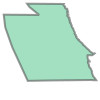

In [35]:
mp = MultiPolygon(shape(geom))
mp

In [36]:
centroid = json.loads(df_areas["centroid"][0])
centroid

[-87.670167, 42.009623]

In [37]:
mp.contains(Point(centroid))

True

In [38]:
other_centroid = json.loads(df_areas["centroid"][13])
other_centroid

[-87.72156, 41.968068]

In [39]:
mp.contains(Point(other_centroid))

False

## Convert ZIP Code Data to Community Area Data

In [164]:
import pandas as pd
import numpy as np

In [207]:
df_spread = pd.read_csv("./pipeline/data/extracted/covid_spread.csv").dropna()

In [208]:
df_spread.head()

,week_number,week_start,week_end,zip,population,cases_weekly
10,20,2020-05-10T00:00:00.000,2020-05-16T00:00:00.000,60603,1174,1.0
11,21,2020-05-17T00:00:00.000,2020-05-23T00:00:00.000,60603,1174,1.0
12,22,2020-05-24T00:00:00.000,2020-05-30T00:00:00.000,60603,1174,0.0
13,23,2020-05-31T00:00:00.000,2020-06-06T00:00:00.000,60603,1174,0.0
14,24,2020-06-07T00:00:00.000,2020-06-13T00:00:00.000,60603,1174,0.0


In [209]:
df_zip_to_area = pd.read_csv("./pipeline/data/extracted/zip_code_to_community_area.csv")
df_zip_to_area.rename(columns={ "ZCTA5": "zip", "CHGOCA": "area", "TOT2010": "pop" }, inplace=True)

In [210]:
df_zip_to_area.head(10)

,zip,area,pop
0,60007,76,0
1,60018,76,1
2,60068,9,0
3,60106,76,0
4,60131,76,0
5,60176,76,0
6,60601,32,11110
7,60602,32,1204
8,60603,32,493
9,60604,32,570


Quick data quality checks: How many areas are there per zip code? How common is it to have that many areas?

In [211]:
areas_per_zip = df_zip_to_area \
    .groupby(by="zip")["area"] \
    .count().reset_index() \
    .rename(columns={ "area": "n_areas_per_zip" })
zips_per_number_of_areas_per_zip = areas_per_zip \
    .groupby(by="n_areas_per_zip")["zip"] \
    .count().reset_index() \
    .rename(columns={ "zip": "n_zips" })
zips_per_number_of_areas_per_zip

,n_areas_per_zip,n_zips
0,1,13
1,2,13
2,3,12
3,4,11
4,5,4
5,6,8
6,7,3
7,8,2
8,10,1


In [212]:
areas_per_zip[areas_per_zip["n_areas_per_zip"] == 5]

,zip,n_areas_per_zip
17,60612,5
29,60624,5
38,60634,5
40,60637,5


Our algorithm for converting from zip codes to community areas is:

- Assume each zip code belongs to one or more community areas
- Assume each row represents the number of people (based on 2010 population estimate) from the given zip code who live in the given community area
- Compute the fraction of the community area population in that zip code: (numerator: population of the zip in the community area) / (denominator: total population of the community area)
- Assume that any community area measure is distributed across zip codes in that community area in proportion to the fraction of the community area population in that zip code (big assumption!)
- Multiply the zip code measure by this proportion to get the fraction of that measure for this zip and area
- Add up all the fractional measures for each area to get the community area converted value

Some caveats to this:

- Some zip codes overlap with areas that are outside Chicago, so converted totals may not add up the original zip code amount
- The assumption that the measure is distributed according to population is probably not correct! But we hope this will be a simple way to convert and that errors will be smoothed out between zip codes
- For integer measures, we will round the proportion values up if they are at least 0.5 and down otherwise
- For measures like number of COVID cases, where the values start out small, this rounding strategy could throw off early counts by a lot! For now, we are ignoring that worry, but a consequence is that if you wanted to know when the first case was detected for a given community area, you would not be able to tell, we are just making a guess, and our guess will choose the community area with the largest share of the zip code population

In [213]:
df_area_pop = df_zip_to_area.groupby(by="area")["pop"].sum().reset_index()
df_area_pop.head()

,area,pop
0,1,54991
1,2,71942
2,3,56362
3,4,39493
4,5,31867


In [239]:
df_zip_to_area_frac = df_zip_to_area.set_index("area") \
    .join(df_area_pop.set_index("area"), rsuffix="_area").reset_index()
df_zip_to_area_frac["pop_frac_area"] = df_zip_to_area_frac["pop"] / df_zip_to_area_frac["pop_area"]
df_zip_to_area_frac.head()

,area,zip,pop,pop_area,pop_frac_area
0,1,60626,48980,54991,0.890691
1,1,60645,5820,54991,0.105836
2,1,60660,191,54991,0.003473
3,2,60626,1159,71942,0.016110
4,2,60645,39454,71942,0.548414


In [240]:
print(f"{len(df_zip_to_area)} rows in `df_zip_to_area`")
print(f"{len(df_zip_to_area_frac)} rows in `df_zip_to_area_frac`")
assert len(df_zip_to_area) == len(df_zip_to_area_frac), "Number of rows should be the same after join."
assert len(df_zip_to_area_frac) \
    == len(df_zip_to_area_frac[["area", "zip"]].drop_duplicates()), "Rows should be unique on area and zip."

234 rows in `df_zip_to_area`
234 rows in `df_zip_to_area_frac`


In [241]:
df_spread.head()

,week_number,week_start,week_end,zip,population,cases_weekly
10,20,2020-05-10T00:00:00.000,2020-05-16T00:00:00.000,60603,1174,1.0
11,21,2020-05-17T00:00:00.000,2020-05-23T00:00:00.000,60603,1174,1.0
12,22,2020-05-24T00:00:00.000,2020-05-30T00:00:00.000,60603,1174,0.0
13,23,2020-05-31T00:00:00.000,2020-06-06T00:00:00.000,60603,1174,0.0
14,24,2020-06-07T00:00:00.000,2020-06-13T00:00:00.000,60603,1174,0.0


In [242]:
df_zip_to_area_frac.head()

,area,zip,pop,pop_area,pop_frac_area
0,1,60626,48980,54991,0.890691
1,1,60645,5820,54991,0.105836
2,1,60660,191,54991,0.003473
3,2,60626,1159,71942,0.016110
4,2,60645,39454,71942,0.548414


In [243]:
df_spread["zip"] = df_spread["zip"].astype(str)
df_zip_to_area_frac["zip"] = df_zip_to_area_frac["zip"].astype(str)

In [244]:
df_spread_zip_and_area = pd.merge(left=df_spread, right=df_zip_to_area_frac, on="zip")
df_spread_zip_and_area.rename(columns={ "cases_weekly": "cases_weekly_zip" }, inplace=True)
df_spread_zip_and_area.head()

,week_number,week_start,week_end,zip,population,cases_weekly_zip,area,pop,pop_area,pop_frac_area
0,20,2020-05-10T00:00:00.000,2020-05-16T00:00:00.000,60603,1174,1.0,32,493,29283,0.016836
1,21,2020-05-17T00:00:00.000,2020-05-23T00:00:00.000,60603,1174,1.0,32,493,29283,0.016836
2,22,2020-05-24T00:00:00.000,2020-05-30T00:00:00.000,60603,1174,0.0,32,493,29283,0.016836
3,23,2020-05-31T00:00:00.000,2020-06-06T00:00:00.000,60603,1174,0.0,32,493,29283,0.016836
4,24,2020-06-07T00:00:00.000,2020-06-13T00:00:00.000,60603,1174,0.0,32,493,29283,0.016836


In [245]:
print(f"{len(df_spread)} rows in `df_spread`")
print(f"{len(df_spread_zip_and_area)} rows in `df_spread_zip_and_area`")

3462 rows in `df_spread`
13152 rows in `df_spread_zip_and_area`


In [246]:
df_spread_zip_and_area["cases_weekly_zip_area_frac"] \
    = df_spread_zip_and_area["cases_weekly_zip"] * df_spread_zip_and_area["pop_frac_area"]
df_spread_zip_and_area["cases_weekly_zip_area"] \
    = df_spread_zip_and_area["cases_weekly_zip_area_frac"].apply(np.round)

In [247]:
df_spread_zip_and_area = df_spread_zip_and_area[[
    "week_start",
    "week_end",
    "zip",
    "area",
    "pop_frac_area",
    "cases_weekly_zip",
    "cases_weekly_zip_area_frac",
    "cases_weekly_zip_area"
]].sort_values(by=["week_end", "zip", "area"], ascending=True)

In [248]:
df_spread_zip_and_area.head(10)

,week_start,week_end,zip,area,pop_frac_area,cases_weekly_zip,cases_weekly_zip_area_frac,cases_weekly_zip_area
1500,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60610,7,0.004008,5.0,0.020042,0.0
1501,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60610,8,0.465459,5.0,2.327295,2.0
1502,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60610,24,0.000086,5.0,0.000430,0.0
2186,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60613,3,0.233508,5.0,1.167542,1.0
2187,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60613,5,0.123764,5.0,0.618822,1.0
2188,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60613,6,0.330366,5.0,1.651831,2.0
2557,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60614,5,0.009446,14.0,0.132237,0.0
2558,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60614,6,0.018195,14.0,0.254726,0.0
2559,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60614,7,0.991094,14.0,13.875320,14.0
2560,2020-03-08T00:00:00.000,2020-03-14T00:00:00.000,60614,22,0.014322,14.0,0.200503,0.0


In [249]:
df_spread_zip_and_area.groupby(by=["week_end", "area"])["cases_weekly_zip_area"].sum().reset_index().head()

,week_end,area,cases_weekly_zip_area
0,2020-03-14T00:00:00.000,3,1.0
1,2020-03-14T00:00:00.000,4,0.0
2,2020-03-14T00:00:00.000,5,7.0
3,2020-03-14T00:00:00.000,6,11.0
4,2020-03-14T00:00:00.000,7,14.0
